<a href="https://colab.research.google.com/github/hereagain-Y/TF_tutorial/blob/main/Extract_TCR_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.spatial import distance

from six.moves import xrange
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# New section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
s = []
my_file = open("/content/drive/My Drive/DL/VAE/Newdata/short_Tumor.txt", "r")
content_list = my_file.read().splitlines()
content_list=np.array(content_list)
d= {} # bipphysics dictionary
with open("/content/drive/My Drive/DL/VAE/AAidx_PCA.txt") as f:
    next(f)
    for line in f.readlines():
        line=line.strip().split('\t') #
        AA=line[0]
        tag=0
        values=[]
        for PC in line[1:]:
            values.append(float(PC))
        if tag==1: 
            continue
        d[AA]=values

def normalize(d):
  result = {}
  for key, value in d.items():
    maxval = max(d[key])
    minval = min(d[key])
    newval=[]
    for number in value:

      newval.append((number-minval)/(maxval-minval))
    
    result[key] =newval
  return(result)

d_norm=normalize(d)
# max length
#comp_seq=data["amino_acid"].tolist()

comp_seq=content_list

print(comp_seq)
max_len=-1 

for AA in comp_seq:
    if len(AA)>max_len:
        max_len=len(AA)
        #res=AA
print(max_len )

"""Load AA index data

# normalization
"""

PC_length=len(d_norm['C'])
def AAindexEncoding(Seq):
    length_seq=len(Seq)
    global max_len
    AAE=np.zeros([max_len,15])
    if length_seq<max_len:
        for amino in range(length_seq):
            AA=Seq[amino]# 
            AAE[amino,]=d_norm[AA] # add PC value 
            
        for amino in range(length_seq,max_len):
            AAE[amino,]=np.zeros(15)
    else: 
        for amino in range(length_seq): # zero padding
            AA=Seq[amino]# 
            AAE[amino,]=d_norm[AA]
        
    #AAE=np.transpose(AAE.astype(np.float32)) # row as PC. and column as AA sequence 
    return AAE 
  
def GetFeatures(file):
    #sequence=file['amino_acid'].tolist()
    #sequence=np.array(sequence)
    #sequence = file.read().splitlines()
    #sequence=np.array(sequence)
    hot_encode=[]
    for seq in file:
        hot_encode.append(AAindexEncoding(seq))
    hot_encode=np.array(hot_encode)
    result=np.array(hot_encode)
    return(result) # dimension: number of sequence [15*length(sequence)]

def reconstructSequence(dict,data):
  result = []
  for i in range(len(data)):
    currentSeq= ''
    dict_index=list(dict.keys())
    if(i%1000==0):
      print(str(i/len(data)*100)+'%')
    for j in range(len(data[i])):
      row = data[i][j]
      max_value= np.max(row)
      if max_value <= 0.1:
        continue
      #calculate distance
      dist = []
      for key, value in dict.items():
        dist.append(distance.euclidean(dict[key], row))
      currentSeq += dict_index[np.argmin(dist)]
    result.append(currentSeq)
  return result
def CompareSeq(dict,data,correct):
  result=[]
  result=reconstructSequence(dict,data)
  index = 0
  print("start comparing sequence")
  for i in range(len(result)):
    if result[i]==correct[i]:
      index += 1
  Accu=index/len(result)
  print(f'the accuracy is {Accu:.1%}')


r1=GetFeatures(content_list)

['PPTGIVYGY' 'DWTDQPQ' 'SQYDEQ' ... 'GATETQ' 'RGDRGITDTQ' 'SMGGSDEQ']
44


In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} 
r1_transform=torch.from_numpy(r1) # from np to tensor
r1_transform=r1_transform.float()
r1_transform.shape
train_ds, test_ds =torch.utils.data.random_split(r1_transform, (int(0.8*len(r1_transform)), len(r1_transform)-int(0.8*len(r1_transform))))
print(train_ds, test_ds)

train_loader = DataLoader(dataset=train_ds, batch_size=1000)
test_loader  = DataLoader(dataset=test_ds,  batch_size=1000)
cuda = True
DEVICE = torch.device("cuda")

<torch.utils.data.dataset.Subset object at 0x7f2f7ca8fa90> <torch.utils.data.dataset.Subset object at 0x7f2f7d426150>


In [ ]:
#change parameter 
batch_size = 1000
x_dim=660 # 44*15
hidden_dim = 256

latent_dim = 128
lr = 1e-3

	Epoch 0 complete! 	Average Loss:  186.3029619140625 	Average Test Loss:  106.55078125
	Epoch 100 complete! 	Average Loss:  86.91079557291667 	Average Test Loss:  87.05957161458333
	Epoch 200 complete! 	Average Loss:  85.55633268229167 	Average Test Loss:  85.72775520833333
	Epoch 300 complete! 	Average Loss:  84.99784895833334 	Average Test Loss:  85.20959114583333
	Epoch 400 complete! 	Average Loss:  84.68301302083333 	Average Test Loss:  84.92828645833333
	Epoch 500 complete! 	Average Loss:  84.45413346354167 	Average Test Loss:  84.76418880208334
	Epoch 600 complete! 	Average Loss:  84.28274153645833 	Average Test Loss:  84.5839453125
	Epoch 700 complete! 	Average Loss:  84.22044791666667 	Average Test Loss:  84.64894270833334
	Epoch 800 complete! 	Average Loss:  84.11027701822917 	Average Test Loss:  84.43404947916666
	Epoch 900 complete! 	Average Loss:  84.076123046875 	Average Test Loss:  84.49594140625
Finish!!
plot curves
==train end===


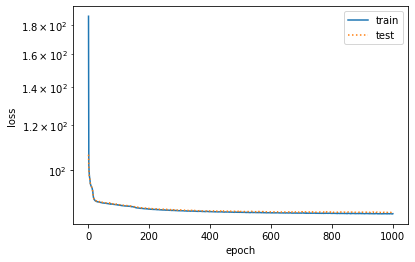

In [ ]:
epochs = 1000

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.hsize = int(1.5*input_dim)
        self.FC_input = nn.Linear(input_dim, self.hsize)
        self.FC_input1 = nn.Linear(self.hsize, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        #self.FC_input3 = nn.Linear(hidden_dim, hidden_dim2)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.relu = nn.ReLU()  
        self.dropout1= nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)     
        self.training = True
        
    def forward(self, x):
        h_       = self.relu(self.FC_input(x))
        #h_       = self.dropout1(h_)
        h_       = self.relu(self.FC_input1(h_))
        #h_       = self.dropout1(h_)
        h_       = self.relu(self.FC_input2(h_))
        #h_       = self.relu(self.FC_input3(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                     #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim,output_dim):
        super(Decoder, self).__init__()
        self.hsize = int(1.5*output_dim)
        self.FC_hidden1 = nn.Linear(latent_dim, hidden_dim)
        #self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_hidden = nn.Linear(hidden_dim, self.hsize)
        self.FC_output = nn.Linear(self.hsize, output_dim)      
        self.relu = nn.ReLU()
       # self.dropout1= nn.Dropout(p=0.3)
       # self.dropout2 = nn.Dropout(p=0.3)
        
    def forward(self, x):
        h     = self.relu(self.FC_hidden1(x))
        #h     = self.dropout1(h)
        #h     = self.relu(self.FC_hidden3(h))
        h     = self.relu(self.FC_hidden2(h))
        #h     = self.dropout1(h)
        h     = self.relu(self.FC_hidden(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        #x_hat = self.relu(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon 
        #z  = mean                       # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var) ]
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim,latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim,output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # try MSE 
    #MSELoss_criterion = nn.MSELoss()
    #reproduction_loss = MSELoss_criterion(x_hat, x) 
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD, reproduction_loss


optimizer = Adam(model.parameters(), lr=lr)   

train_loss= [] # before epoch
testtoal_loss= []
reproduction1=[]
reproduction2=[]

def plotCurve(x_vals,y_vals,x_label, y_label,
              x2_vals=None, y2_vals=None, legend=None,figsize=(3.5,2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
    
    if legend:
        plt.legend(legend)
for epoch in range(epochs):
    overall_loss = 0
    overall_testloss= 0
    overall_res = 0
    overall_testres= 0
    
    for batch_idx, x in enumerate(train_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss, reproduction_loss = loss_function(x, x_hat, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
        overall_res += reproduction_loss.item()
    train_loss.append(overall_loss/len(train_ds))
    reproduction1.append(overall_res/len(train_ds))

      #test loss
    for batch_idx, x in enumerate(test_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        #optimizer.zero_grad()

        pred, mean, log_var = model(x)
        test_loss, test_reproduction= loss_function(x, pred, mean, log_var)
        overall_testloss += test_loss.item()
        overall_testres += test_reproduction.item()
    testtoal_loss.append(overall_testloss/len(test_ds))
    reproduction2.append(overall_testres/len(test_ds))

    if (epoch % 100 == 0):
      #print('====> Epoch %d done! Average Loss:  = %.2e, Average test loss = %.2e' % (epoch,overall_loss / (batch_idx*batch_size),overall_testloss/(batch_idx*batch_size)))
        
        
      print("\tEpoch", epoch , "complete!", "\tAverage Loss: ", train_loss[epoch],#overall_loss / (batch_idx*batch_size),
        "\tAverage Test Loss: " , testtoal_loss[epoch])
    
print("Finish!!")
print("plot curves")
plotCurve(range(1,epochs+1),train_loss,"epoch","loss",
          range(1,epochs+1),testtoal_loss,
          ['train','test'])


print('==train end===')

In [ ]:
torch.save(model, '/content/drive/My Drive/DL/VAE/Newdata/VAE_extract_modify_model_1000_echo.apx')
model = torch.load('/content/drive/My Drive/DL/VAE/Newdata/VAE_extract_modify_model_1000_echo.apx')

In [ ]:
my_file2 = open("/content/drive/My Drive/DL/VAE/Newdata/short_Tumortest.txt", "r")
content_list2 = my_file2.read().splitlines()

neww=np.array(content_list2)

#neww=[x for x in content_list2 if len(x)<=13]

neww=np.array(neww)
r2=GetFeatures(neww)
r2_transform=torch.from_numpy(r2).float() # change to tensor and float 
m2=r2_transform.view(len(r2_transform),660) # flatten 
#m2 = torch.from_numpy(m2).float()
#result = model(m2)[0] # 
result = model(m2.cuda())[0]
result2 = result.view( len(result),44,15 ).cpu().detach().numpy()


seq_decode=reconstructSequence(d_norm,result2)
#content_list2
seq_decode[:10]

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


['KSQGGDEQ',
 'LSSSSYGY',
 'SSSSSGKL',
 'LSSQDTQA',
 'QSSGGNEQ',
 'LPSSGGNTGEL',
 'LSSSTDTQ',
 'LSSSGSDGY',
 'LPSSGGSDTQ',
 'SSLYEQ']

In [ ]:
neww[:10]

array(['GTVGESEQ', 'WNEGRYGY', 'SGTGDEKL', 'IRNPETQ', 'RTSGRREQ',
       'LSGGHSNTGEL', 'QVDGTDTQ', 'PQGQGEGGY', 'LGTSGRGETQ', 'SVSYEQ'],
      dtype='<U29')

In [ ]:
seq_decode[:10]

['KSQGGDEQ',
 'LSSSSYGY',
 'SSSSSGKL',
 'LSSQDTQA',
 'QSSGGNEQ',
 'LPSSGGNTGEL',
 'LSSSTDTQ',
 'LSSSGSDGY',
 'LPSSGGSDTQ',
 'SSLYEQ']

In [ ]:
CompareSeq(d_norm,result2,neww)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
start comparing sequence
the accuracy is 0.0%


In [ ]:
a= neww[3]
b= seq_decode[3]

In [ ]:
len(seq_decode)

10000

In [ ]:
len(content_list2)

10000

In [ ]:
a


'IRNPETQ'

In [ ]:
b

'PSGSETQ'

In [ ]:
def compare_percent (seq1,seq2):
  return float(sum(seq1[i]==seq2[i] for i in range(len(seq1)))/len(seq1))

In [ ]:
compare_percent(seq_decode[1],neww[1])

0.5

In [ ]:
def compare_percent (seq1,seq2):
  return float(sum(seq1[i]==seq2[i] for i in range(len(seq1)))/len(seq1))

def CoverageSeq(data,correct):
  print("start comparing sequence")
  percentage = []
  for i in range(len(data)):
    percentage.append(compare_percent(data[i],correct[i]))
  #Accu = sum(percentage)/len(percentage)   
  #print(f'the average coverage is {Accu:.1%}')
  return(percentage)
 
  

In [ ]:
with open(r'/content/drive/My Drive/DL/VAE/Newdata/Tumor_prediction.txt','w') as fp:
    fp.write('\n'.join(seq_decode))

In [ ]:
CoverageSeq(seq_decode[:100],neww[:100])

start comparing sequence


IndexError: ignored